<a href="https://colab.research.google.com/github/ysmnpksy/Final-Project/blob/main/LSTMGRULayers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>AI CW2: Universal Workflow on IMDB Spoilers Dataset</h1>
By Yasmin Paksoy

# Table of Contents 
  * [Preparing the Data](#section1)
  * [Build Functions](#build)
  * [Model 1: First LSTM Model](#model2)
  * [Tuning: Dropout](#dropout)
    * [Model 2: Rate 20%](#model3)
    * [Model 3: Rate 40%](#model4)
    * [Model 4: Rate 50%](#model5)
  * [Tuning: Number of Layers](#layers)
    * [Failed Model: 2 Layers](#model6)
  * [Model 5: GRU](#model7)
  * [Tuning Learning Rate](#Learning-Rate)
    * [Model 6: 0.003](#model8)
    * [Model 7: 0.006](#model9)
    * [Model 8: 0.004](#model10)
    * [Model 9: 0.01](#model11)
  * [Training Final Model](#FinalModel)

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yasminpaksoy","key":"9092d77ded0787db0dc92dec0c6c058c"}'}

In [ ]:
# making kaggle directory 
! mkdir ~/.kaggle

# copying api login info into directory 
! cp kaggle.json ~/.kaggle/

# allocating required permissions 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download rmisra/imdb-spoiler-dataset

# unzipping dataset 
! unzip imdb-spoiler-dataset.zip

 98% 326M/331M [00:03<00:00, 108MB/s]
100% 331M/331M [00:03<00:00, 95.1MB/s]
Archive:  imdb-spoiler-dataset.zip
  inflating: IMDB_movie_details.json  
  inflating: IMDB_reviews.json       


In [ ]:
# importing pandas to read the JSON files
import pandas as pd 

# information regarding reviews file
all_reviews = pd.read_json('../content/IMDB_reviews.json', lines=True)

print('Total number of reviews:', all_reviews['review_date'].count())
print('Total number of reviews that contain spoilers:', all_reviews['is_spoiler'].sum())
print('User reviews shape:', all_reviews.shape)
print()

print('First 5 user reviews:')
all_reviews.head()

Total number of reviews: 573913
Total number of reviews that contain spoilers: 150924
User reviews shape: (573913, 7)

First 5 user reviews:


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Preparing the Data <a class="anchor" id="preparing"></a>
--------------------------------
As shown in previous code cells, the reviews database contains 573,913 records, 150,924 of them which contain spoilers. Since the difference between reviews with spoilers and without are so big, I will be balancing the dataset before moving forward. 

In the code cell below, I am converting the reviews and their labels into lists from the JSON file they were loaded in with. During this process, I am adding all reviews that contain spoilers to this list but only 150,924 reviews that don't. This leaves me with a fully balances dataset, which can be seen in the calculations below. 

In [ ]:
import json

labels = [] 
texts = []
sum = 0; 

with open('IMDB_reviews.json', 'r') as json_file:
  for jsonObj in json_file:
    data = json.loads(jsonObj)
    if data['is_spoiler'] == True:
      labels.append(1)
      texts.append(data['review_text'])
    else:
      if sum < 150924:
        sum += 1
        labels.append(0)
        texts.append(data['review_text'])

In [ ]:
spoilers = 0;
nonSpoilers = 0;

for i in labels: 
  if i == 1: 
    spoilers += 1 
  else: 
    nonSpoilers += 1

print("Total number of reviews: " + str(len(labels)))
print("Total nummber with spoilers: " + str(spoilers))
print("Total number without spoilers " + str(nonSpoilers))

Total number of reviews: 301848
Total nummber with spoilers: 150924
Total number without spoilers 150924


Next, I am preparing the data. For this data to be inputted into a machine-learning model, it needs to be formatted into tensors which are small in value and normalized if heterogeneous. Heterogeneous data refers to the data being in different ranges, and while deep neural networks can adapt to this, it makes learning more difficult [1]. 

The data is currently not in tensors, so I will be tokenizing the text data using one-hot encoding. To do this I am using the `Tokenizer` module from Keras. I have cut the reviews of after a maximum of 500 words and am only considering the most frequent 15000 words in the dataset. 

After tokenizing, I have vectorized the data using the `pad_sequences` module from Keras, which converts the list of tokenized data, integers, into 2D tensors, which can then be fed into the neural network. I have also vectorized the list of labels by converting it to a list of floating point numbers.

This data is now ready to be inputted into a machine-learning model. 

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 500 # cuts reviews off after 500 words 
max_words = 15000 # considers only the top 15,000 words in the dataset 

# tokenizing texts 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# vectorizing texts
data = pad_sequences(sequences, maxlen=maxlen)

# vectorizing labels 
labels = np.asarray(labels).astype('float32')

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 282338 unique tokens.
Shape of data tensor: (301848, 500)
Shape of label tensor: (301848,)


Lastly, to prepare the data, I am splitting it into training and testing sets. This way I will be testing the model on unseen data only, ensuring information leaking does not affect the final results. I will be training on 201,848 data points and testing on 100,00.

I am first shuffling the data, since the JSON file lists all reviews including spoilers first, then splitting it.

In [ ]:
# suffling data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# setting number of training and testing samples
training_samples = 251848
testing_samples = 50000

# splitting into training and testing sets
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + testing_samples]
y_test = labels[training_samples: training_samples + testing_samples]

In [ ]:
print('Training data shape:',x_train.shape)
print('Training labels shape:', y_train.shape)

print('Test data shape:',x_test.shape)
print('Test labels shape:',y_test.shape)

Training data shape: (251848, 500)
Training labels shape: (251848,)
Test data shape: (50000, 500)
Test labels shape: (50000,)


Here I am further splitting the training set into partial training and validation. This ensures that the data used to validate will not be the same as that used to train, helping avoid overfitting issues. I will be training on 151,848 samples and validating on 50,000. 

In [ ]:
# setting number of training and validation samples
partial_training_samples = 201848
validation_samples = 50000

# splitting into training and validation sets
x_partial_train = data[:partial_training_samples]
y_partial_train = labels[:partial_training_samples]
x_val = data[partial_training_samples: partial_training_samples + validation_samples]
y_val = labels[partial_training_samples: partial_training_samples + validation_samples]

In [ ]:
print('Partial training data shape:',x_partial_train.shape)
print('Partial training labels shape:', y_partial_train.shape)

print('Validation data shape:',x_val.shape)
print('Validation labels shape:',y_val.shape)

Partial training data shape: (201848, 500)
Partial training labels shape: (201848,)
Validation data shape: (50000, 500)
Validation labels shape: (50000,)


# Build Functions <a class="anchor" id="build"></a>
---------------------
I have included all the functions I will use below.

The code functions I have included are: 
* Build baseline model. 
* Build scaled up model. 
* Build model with dropout and recurrent dropout. 
* Plot loss function. 
* Plot final loss function. 
* Plot accuracy function. 
* Plot final accuracy function. 
* Train function. 
* Train final model function. 
* Evaluate function. 



In [ ]:
# Importing all necessary libraries
import tensorflow as tf
import keras
import matplotlib.pyplot as plt


from gc import callbacks
from keras import models, layers
from tensorflow.keras import optimizers
from keras.layers import Embedding, Flatten, LSTM

In [ ]:
def build_small():
  model = models.Sequential()
  
  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8, input_length=maxlen))
  
  # flattens the 3D tensor output to a 2D tensor
  model.add(Flatten())
  
  # training single dense layer for classfication  
  model.add(layers.Dense(32, activation = 'relu'))
  # output layer 
  model.add(layers.Dense(1, activation = 'sigmoid'))
  
  model.compile(optimizer = 'rmsprop', 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])
  model.build()
  model.summary()
  return model

In [ ]:
def build_scaled_up():
  model = models.Sequential()

  # Embedding layers 
  # network will learn 32-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  model.add(LSTM(32))
  # output layer
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_dropout(drop, rec_drop):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop
                 ))
  
  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_layers(drop, rec_drop, layer):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  #for i in range(layer):
  model.add(LSTM(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500), 
                 return_sequences=True))
  
  if layer==2:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))
    
  if layer==3:
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop,
                   return_sequences=True))
    model.add(LSTM(32,
                   dropout=drop,
                   recurrent_dropout=rec_drop))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_GRU(drop, rec_drop):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  #for i in range(layer):
  model.add(layers.GRU(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500)))

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def build_learning_rate(drop, rec_drop, lr):
  model = models.Sequential()

  # Embedding layers 
  # network will learn 8-dimensional embeddings for each of the 15,000 words
  model.add(Embedding(15000, 8))

  # LSTM layer
  # includes dropout and reccurrent dropout 
  #for i in range(layer):
  model.add(layers.GRU(32, 
                 dropout=drop,
                 recurrent_dropout=rec_drop,
                 input_shape=(151848, 500))
  )

  # output layer 
  model.add(layers.Dense(1, activation='sigmoid'))
  
  model.compile(optimizer = optimizers.RMSprop(learning_rate = lr),
                loss='binary_crossentropy',
                metrics=['acc'])
  model.build()
  model.summary()
  return model 

In [ ]:
def plot_outputs():

  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5
    )]

In [ ]:
def train(model, epoch):
  return model.fit(x_partial_train, y_partial_train,
                   epochs = epoch,
                   batch_size = 128,
                   callbacks = callbacks_list,
                   validation_data = (x_val, y_val))

In [ ]:
def train_final_model(model, epoch):
  return model.fit(x_train, y_train, epochs = epoch, batch_size = 128)

In [ ]:
def evaluate():
  model.evaluate(x_test, y_test)

# Model 1: First LSTM Model<a class="anchor" id="model2"></a>
-------------------------

In [ ]:
model = build_scaled_up()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 462s 292ms/step - loss: 0.5871 - acc: 0.6945 - val_loss: 0.5397 - val_acc: 0.7311
Epoch 2/50
1577/1577 [==============================] - 458s 290ms/step - loss: 0.5303 - acc: 0.7452 - val_loss: 0.5295 - val_acc: 0.7463
Epoch 3/50
1577/1577 [==============================] - 464s 294ms/step - loss: 0.5125 - acc: 0.7587 - val_loss: 0.5143 - val_acc: 0.7477
Epoch 4/50
1577/1577 [==============================] - 460s 292ms/step - loss: 0.5050 - acc: 0.7628 - val_loss: 0.5111 - val_acc: 0.7549
Epoch 5/50
1577/1577 [==============================] - 460s 292ms/step - loss: 0.4943 - acc: 0.7686 - val_loss: 0.5079 - val_acc: 0.7554
Epoch 6/50
1577/1577 [==============================] - 462s 293ms/step - loss: 0.4856 - acc: 0.7740 - val_loss: 0.5131 - val_acc: 0.7525
Epoch 7/50
1577/1577 [==============================] - 462s 293ms/step - loss: 0.4773 - acc: 0.7776 - val_loss: 0.5093 - val_acc: 0.7500
Epoch 8/50
1577/1577 [============

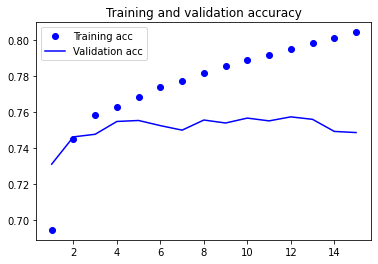

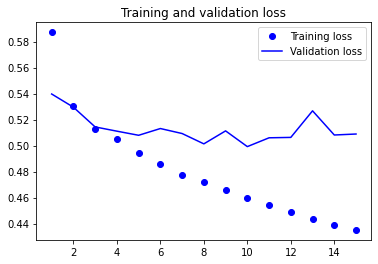

In [ ]:
plot_outputs()

# Tuning: Dropout <a class="anchor" id="dropout"></a>
------------

## Model 2: Rate 20% <a class="anchor" id="model3"></a>
-----------------------

In [ ]:
model = build_dropout(0.2, 0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 8)           120000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                5248      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 995s 629ms/step - loss: 0.5950 - acc: 0.6900 - val_loss: 0.5661 - val_acc: 0.7167
Epoch 2/50
1577/1577 [==============================] - 992s 629ms/step - loss: 0.5394 - acc: 0.7417 - val_loss: 0.5380 - val_acc: 0.7321
Epoch 3/50
1577/1577 [==============================] - 989s 627ms/step - loss: 0.5216 - acc: 0.7535 - val_loss: 0.5292 - val_acc: 0.7492
Epoch 4/50
1577/1577 [==============================] - 984s 624ms/step - loss: 0.5098 - acc: 0.7600 - val_loss: 0.5378 - val_acc: 0.7502
Epoch 5/50
1577/1577 [==============================] - 986s 625ms/step - loss: 0.5034 - acc: 0.7613 - val_loss: 0.5110 - val_acc: 0.7488
Epoch 6/50
1577/1577 [==============================] - 998s 633ms/step - loss: 0.4928 - acc: 0.7686 - val_loss: 0.5091 - val_acc: 0.7551
Epoch 7/50
1577/1577 [==============================] - 996s 632ms/step - loss: 0.4870 - acc: 0.7714 - val_loss: 0.5103 - val_acc: 0.7532
Epoch 8/50
1577/1577 [============

Below I have included graphs showing the training and validation accuracy and loss of this model:


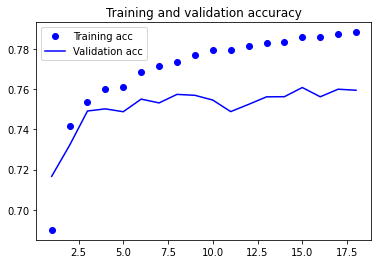

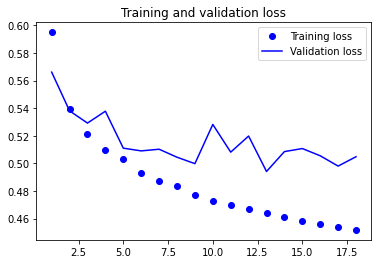

In [ ]:
plot_outputs()

## Model 3: Rate 40% <a class="anchor" id="model4"></a>
-----------------------

In [ ]:
model = build_dropout(0.4, 0.4)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1140s 717ms/step - loss: 0.6202 - acc: 0.6626 - val_loss: 0.5539 - val_acc: 0.7264
Epoch 2/50
1577/1577 [==============================] - 1125s 714ms/step - loss: 0.5634 - acc: 0.7260 - val_loss: 0.5533 - val_acc: 0.7379
Epoch 3/50
1577/1577 [==============================] - 1122s 711ms/step - loss: 0.5412 - acc: 0.7402 - val_loss: 0.5335 - val_acc: 0.7431
Epoch 4/50
1577/1577 [==============================] - 1125s 713ms/step - loss: 0.5268 - acc: 0.7469 - val_loss: 0.5371 - val_acc: 0.7468
Epoch 5/50
1577/1577 [==============================] - 1127s 715ms/step - loss: 0.5142 - acc: 0.7556 - val_loss: 0.5734 - val_acc: 0.7351
Epoch 6/50
1577/1577 [==============================] - 1126s 714ms/step - loss: 0.5103 - acc: 0.7574 - val_loss: 0.5418 - val_acc: 0.7496
Epoch 7/50
1577/1577 [==============================] - 1120s 710ms/step - loss: 0.5018 - acc: 0.7619 - val_loss: 0.5848 - val_acc: 0.7463
Epoch 8/50
1577/1577 [=====

Graphs showing the training and validation loss and accuracy can be found below:

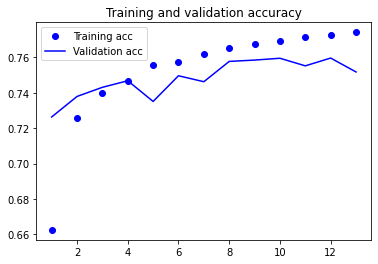

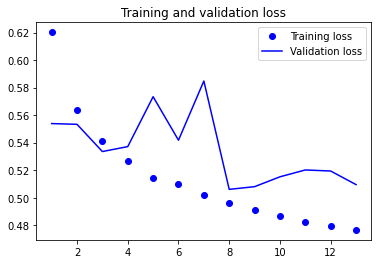

In [ ]:
plot_outputs()

## Model 4: Rate 30% <a class="anchor" id="model5"></a>
-----------------------

In [ ]:
model = build_dropout(0.3, 0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 125,281
Trainable params: 125,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1019s 644ms/step - loss: 0.5977 - acc: 0.6837 - val_loss: 0.5367 - val_acc: 0.7354
Epoch 2/50
1577/1577 [==============================] - 1035s 657ms/step - loss: 0.5519 - acc: 0.7325 - val_loss: 0.5430 - val_acc: 0.7392
Epoch 3/50
1577/1577 [==============================] - 1032s 655ms/step - loss: 0.5255 - acc: 0.7480 - val_loss: 0.5219 - val_acc: 0.7504
Epoch 4/50
1577/1577 [==============================] - 1037s 658ms/step - loss: 0.5145 - acc: 0.7563 - val_loss: 0.5208 - val_acc: 0.7568
Epoch 5/50
1577/1577 [==============================] - 1041s 660ms/step - loss: 0.5065 - acc: 0.7600 - val_loss: 0.5376 - val_acc: 0.7501
Epoch 6/50
1577/1577 [==============================] - 1042s 661ms/step - loss: 0.5026 - acc: 0.7620 - val_loss: 0.5267 - val_acc: 0.7543
Epoch 7/50
1577/1577 [==============================] - 1036s 657ms/step - loss: 0.4955 - acc: 0.7676 - val_loss: 0.5218 - val_acc: 0.7548
Epoch 8/50
1577/1577 [=====

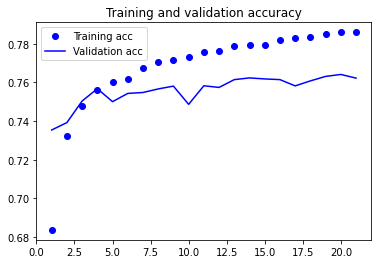

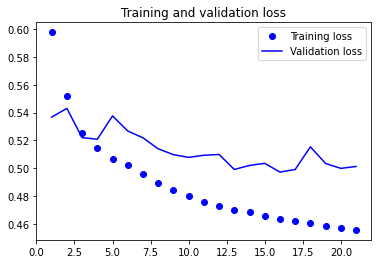

In [ ]:
plot_outputs()

# Tuning: Number of Layers <a class="anchor" id="layers"></a>
----------------------------
Next, I will be changing the architecture by adding layers. Adding layers will increase the capacity of the network, making it more likely to learn important patterns that can allow it to make more accurate predictions. 

## Failed Model: 2 Layers <a class="anchor" id="model6"></a>
--------------------
For the next model, I will be increasing the number of LSTM layers to 2. The model definition can be seen below. 

In [ ]:
model = build_layers(0.4, 0.4, 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 lstm (LSTM)                 (None, None, 32)          5248      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 133,601
Trainable params: 133,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 2239s 1s/step - loss: 0.6039 - acc: 0.6761 - val_loss: 0.5870 - val_acc: 0.6942
Epoch 2/50
1577/1577 [==============================] - 2235s 1s/step - loss: 0.5539 - acc: 0.7291 - val_loss: 0.5353 - val_acc: 0.7395
Epoch 3/50
1577/1577 [==============================] - 2238s 1s/step - loss: 0.5365 - acc: 0.7416 - val_loss: 0.5319 - val_acc: 0.7429
Epoch 4/50
1577/1577 [==============================] - 2248s 1s/step - loss: 0.5246 - acc: 0.7475 - val_loss: 0.5422 - val_acc: 0.7464
Epoch 5/50
1577/1577 [==============================] - 2244s 1s/step - loss: 0.5153 - acc: 0.7541 - val_loss: 0.5193 - val_acc: 0.7512
Epoch 6/50
1577/1577 [==============================] - 2257s 1s/step - loss: 0.5023 - acc: 0.7608 - val_loss: 0.5090 - val_acc: 0.7524
Epoch 7/50
1577/1577 [==============================] - 2313s 1s/step - loss: 0.4907 - acc: 0.7664 - val_loss: 0.5085 - val_acc: 0.7540
Epoch 8/50
1577/1577 [==========================

# Model 5: First GRU Model <a class="anchor" id="model7"></a>
-----------------

In [ ]:
model = build_GRU(0.2, 0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_8 (GRU)                 (None, 32)                4032      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 888s 561ms/step - loss: 0.6111 - acc: 0.6659 - val_loss: 0.5545 - val_acc: 0.7312
Epoch 2/50
1577/1577 [==============================] - 885s 561ms/step - loss: 0.5287 - acc: 0.7449 - val_loss: 0.5158 - val_acc: 0.7501
Epoch 3/50
1577/1577 [==============================] - 890s 564ms/step - loss: 0.5013 - acc: 0.7594 - val_loss: 0.5020 - val_acc: 0.7546
Epoch 4/50
1577/1577 [==============================] - 884s 560ms/step - loss: 0.4868 - acc: 0.7675 - val_loss: 0.5021 - val_acc: 0.7524
Epoch 5/50
1577/1577 [==============================] - 888s 563ms/step - loss: 0.4758 - acc: 0.7738 - val_loss: 0.4925 - val_acc: 0.7589
Epoch 6/50
1577/1577 [==============================] - 888s 563ms/step - loss: 0.4676 - acc: 0.7794 - val_loss: 0.4902 - val_acc: 0.7637
Epoch 7/50
1577/1577 [==============================] - 889s 564ms/step - loss: 0.4607 - acc: 0.7834 - val_loss: 0.4877 - val_acc: 0.7627
Epoch 8/50
1577/1577 [============

In [ ]:
plot_outputs()

# Tuning: Learning Rate <a class="anchor" id="Learning-Rate"></a>
----------------------------

## Model 6: 0.003 <a class="anchor" id="model8"></a>
-----------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.003)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_6 (GRU)                 (None, 32)                4032      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1032s 652ms/step - loss: 0.6055 - acc: 0.6722 - val_loss: 0.5273 - val_acc: 0.7369
Epoch 2/50
1577/1577 [==============================] - 1036s 657ms/step - loss: 0.5074 - acc: 0.7517 - val_loss: 0.4959 - val_acc: 0.7621
Epoch 3/50
1185/1577 [=====================>........] - ETA: 4:06 - loss: 0.4793 - acc: 0.7695

KeyboardInterrupt: ignored

In [ ]:
plot_outputs()

## Model 7: 0.006 <a class="anchor" id="model9"></a>
--------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.006)

In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1017s 641ms/step - loss: 0.5758 - acc: 0.6913 - val_loss: 0.5266 - val_acc: 0.7330
Epoch 2/50
1577/1577 [==============================] - 1030s 653ms/step - loss: 0.4912 - acc: 0.7620 - val_loss: 0.4880 - val_acc: 0.7622
Epoch 3/50
1577/1577 [==============================] - 1024s 649ms/step - loss: 0.4711 - acc: 0.7745 - val_loss: 0.4909 - val_acc: 0.7590
Epoch 4/50
1577/1577 [==============================] - 1029s 653ms/step - loss: 0.4616 - acc: 0.7810 - val_loss: 0.4952 - val_acc: 0.7573
Epoch 5/50
1577/1577 [==============================] - 1019s 646ms/step - loss: 0.4546 - acc: 0.7849 - val_loss: 0.4876 - val_acc: 0.7647
Epoch 6/50
1577/1577 [==============================] - 1023s 648ms/step - loss: 0.4499 - acc: 0.7882 - val_loss: 0.4849 - val_acc: 0.7640
Epoch 7/50
1577/1577 [==============================] - 1028s 652ms/step - loss: 0.4446 - acc: 0.7919 - val_loss: 0.4978 - val_acc: 0.7633
Epoch 8/50
1577/1577 [=====

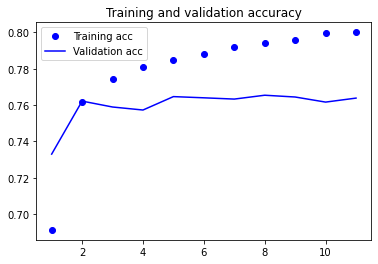

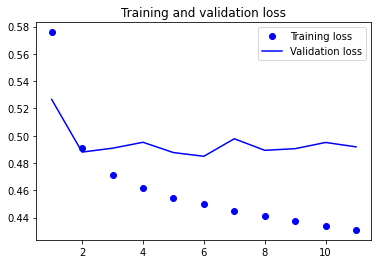

In [ ]:
plot_outputs()

## Model 8: 0.004 <a class="anchor" id="model10"></a>
----------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.004)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_2 (GRU)                 (None, 32)                4032      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1043s 659ms/step - loss: 0.6215 - acc: 0.6486 - val_loss: 0.5264 - val_acc: 0.7449
Epoch 2/50
1577/1577 [==============================] - 1017s 645ms/step - loss: 0.5154 - acc: 0.7459 - val_loss: 0.4993 - val_acc: 0.7572
Epoch 3/50
1577/1577 [==============================] - 998s 633ms/step - loss: 0.4878 - acc: 0.7641 - val_loss: 0.4841 - val_acc: 0.7642
Epoch 4/50
1577/1577 [==============================] - 1020s 647ms/step - loss: 0.4774 - acc: 0.7712 - val_loss: 0.4960 - val_acc: 0.7584
Epoch 5/50
1577/1577 [==============================] - 1022s 648ms/step - loss: 0.4690 - acc: 0.7754 - val_loss: 0.4857 - val_acc: 0.7637
Epoch 6/50
1577/1577 [==============================] - 1019s 646ms/step - loss: 0.4637 - acc: 0.7793 - val_loss: 0.4940 - val_acc: 0.7584
Epoch 7/50
1577/1577 [==============================] - 1032s 654ms/step - loss: 0.4599 - acc: 0.7818 - val_loss: 0.4852 - val_acc: 0.7647
Epoch 8/50
1577/1577 [======

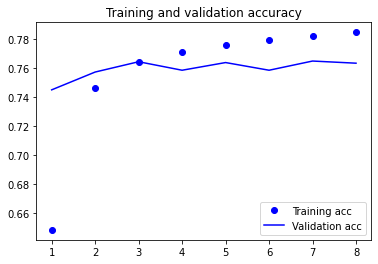

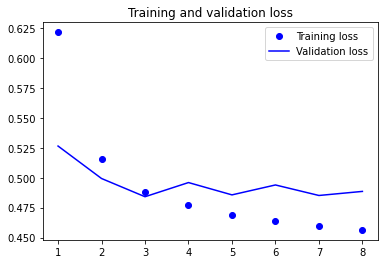

In [ ]:
plot_outputs()

## Model 9: 0.01 <a class="anchor" id="model11"></a>
-----------------

In [ ]:
model = build_learning_rate(0.4, 0.4, 0.01)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 8)           120000    
                                                                 
 gru_4 (GRU)                 (None, 32)                4032      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train(model, 50)

Epoch 1/50
1577/1577 [==============================] - 1015s 641ms/step - loss: 0.5717 - acc: 0.6912 - val_loss: 0.5119 - val_acc: 0.7468
Epoch 2/50
1577/1577 [==============================] - 1008s 639ms/step - loss: 0.4967 - acc: 0.7584 - val_loss: 0.5068 - val_acc: 0.7509
Epoch 3/50
1577/1577 [==============================] - 1017s 645ms/step - loss: 0.4817 - acc: 0.7681 - val_loss: 0.4933 - val_acc: 0.7611
Epoch 4/50
1577/1577 [==============================] - 1027s 651ms/step - loss: 0.4752 - acc: 0.7722 - val_loss: 0.4853 - val_acc: 0.7635
Epoch 5/50
1577/1577 [==============================] - 1017s 645ms/step - loss: 0.4715 - acc: 0.7746 - val_loss: 0.4849 - val_acc: 0.7637
Epoch 6/50
1577/1577 [==============================] - 1020s 647ms/step - loss: 0.4677 - acc: 0.7776 - val_loss: 0.4899 - val_acc: 0.7628
Epoch 7/50
1577/1577 [==============================] - 1020s 647ms/step - loss: 0.4651 - acc: 0.7795 - val_loss: 0.4930 - val_acc: 0.7615
Epoch 8/50
1577/1577 [=====

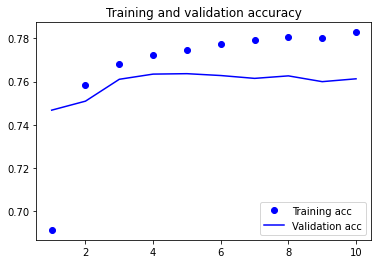

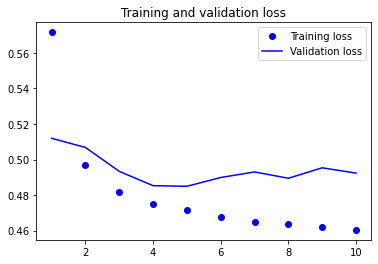

In [ ]:
plot_outputs()

# Training Final Model <a class="anchor" id="FinalModel"></a>
-----------------------------------

In [ ]:
model = build_learning_rate(0.2, 0.2, 0.003)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           120000    
                                                                 
 gru (GRU)                   (None, 32)                4032      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 124,065
Trainable params: 124,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = train_final_model(model, 1)

1968/1968 [==============================] - 1242s 629ms/step - loss: 0.5900 - acc: 0.6874


In [ ]:
results = evaluate()

1563/1563 [==============================] - 85s 54ms/step - loss: 0.5257 - acc: 0.7336


In [ ]:
%%shell
jupyter nbconvert --to html /content/LSTMGRULayers.ipynb

[NbConvertApp] Converting notebook /content/LSTMGRULayers.ipynb to html
[NbConvertApp] Writing 621334 bytes to /content/LSTMGRULayers.html
